# **Problem Description**

## **Overview**
The goal of this project is to classify tweets based on their relevance to real-world disasters. Specifically, the task involves predicting whether a given tweet refers to a real disaster (`target = 1`) or not (`target = 0`). This classification task is a crucial application of natural language processing (NLP) in disaster management and emergency response, where timely and accurate identification of disaster-related content can aid in resource allocation and decision-making.

---

## **Dataset Description**
The dataset is derived from the Kaggle competition **"Natural Language Processing with Disaster Tweets"** and consists of the following:

https://www.kaggle.com/competitions/nlp-getting-started/data

### **Training Data**
- Contains labeled tweets indicating whether they pertain to a real disaster or not.
- Key attributes include:
  - **`id`**: Unique identifier for each tweet.
  - **`keyword`**: Disaster-related keyword extracted from the tweet (may be missing).
  - **`location`**: Location from where the tweet was sent (may be missing).
  - **`text`**: The tweet's content.
  - **`target`**: Binary classification label (`1 = disaster-related`, `0 = not disaster-related`).

### **Test Data**
- Contains tweets without the `target` label, used for evaluating model predictions.

### **Sample Submission**
- A template for submission with:
  - **`id`**: The unique tweet identifier.
  - **`target`**: Placeholder predictions (to be replaced with your model's output).

---

## **Objective**
The objective is to build a robust machine learning model capable of accurately classifying tweets as disaster-related or not. This involves:

1. **Understanding the dataset** through exploratory data analysis (EDA).
2. **Preprocessing and cleaning the text data** to make it suitable for machine learning models.
3. **Feature extraction and engineering** to represent textual data numerically.
4. **Training and evaluating models** using appropriate NLP techniques.
5. **Generating predictions** for the test data to submit on Kaggle.

---

## **Evaluation Metric**
The competition uses the **F1-score** as the primary metric for evaluation. The F1-score balances precision and recall, making it an appropriate choice for this imbalanced dataset where disaster-related tweets are fewer than non-disaster tweets.

---

## **Significance**
Accurately classifying disaster-related tweets is a critical tool for improving disaster response efficiency. By leveraging NLP and machine learning, this project demonstrates how technology can process real-time information from social media, providing actionable insights in crises.


## Data Exploration and Preprocessing

### **1. Explore Data**

#### **Goals**
- Understand the structure and composition of the dataset.
- Identify patterns, inconsistencies, and missing data.
- Gain insights into the distribution of the target variable and other key features.

#### **Steps**
1. **Examine Dataset Shape**
   - Check the number of rows and columns in the training and test datasets.
   - Ensure the datasets have the expected structure.

2. **Inspect Column Types and Missing Values**
   - Identify the data types of each column.
   - Count missing values in the `keyword` and `location` columns.
   - Decide on strategies for handling missing data (e.g., imputation, removal, or flagging).

3. **Analyze Target Variable**
   - Plot the distribution of the `target` column in the training set.
   - Check for class imbalance.

4. **Explore `keyword` Column**
   - Count the number of unique keywords.
   - Analyze the most and least common keywords.
   - Check if specific keywords strongly correlate with the `target` variable.

5. **Explore `location` Column**
   - Count the number of unique locations.
   - Analyze the most common locations.
   - Check if locations have any relationship with the `target` variable.

6. **Explore `text` Column**
   - Examine a few sample tweets for context.
   - Calculate basic statistics:
     - Average tweet length (number of characters and words).
     - Distribution of tweet lengths.
   - Identify common words or phrases.

7. **Check for Duplicates**
   - Identify duplicate rows in the training data.
   - Decide whether to remove duplicates.

8. **Visualize Key Insights**
   - Use bar charts, word clouds, and histograms to represent data patterns.
   - Compare distributions of features for disaster-related vs. non-disaster tweets.

---

#### **Output of Data Exploration**
- A clear understanding of the dataset's structure and content.
- Identification of any data quality issues or preprocessing needs.
- Insights that may inform feature engineering and model design.


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam


In [109]:
# Load the datasets
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

# Step 1: Examine Dataset Shape
print("Train Dataset Shape:", train_df.shape)
print("Test Dataset Shape:", test_df.shape)

# Step 2: Inspect Column Types and Missing Values
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())


Train Dataset Shape: (7613, 5)
Test Dataset Shape: (3263, 4)

Missing Values in Train Dataset:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test Dataset:
id             0
keyword       26
location    1105
text           0
dtype: int64


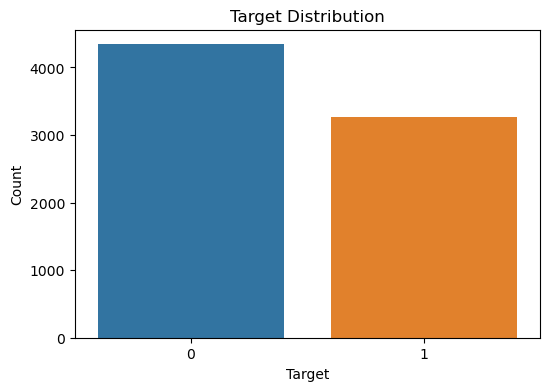

In [110]:
# Step 3: Analyze Target Variable
target_distribution = train_df['target'].value_counts().reset_index()
target_distribution.columns = ['target', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(
    x="target", 
    y="count", 
    data=target_distribution, 
    palette=sns.color_palette("tab10")[:2],  # Limit to two colors for binary targets
    legend= False,
    hue="target"
)
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()



Number of Unique Keywords: 221

Top 5 Keywords:
keyword
fatalities    45
deluge        42
armageddon    42
sinking       41
damage        41
Name: count, dtype: int64


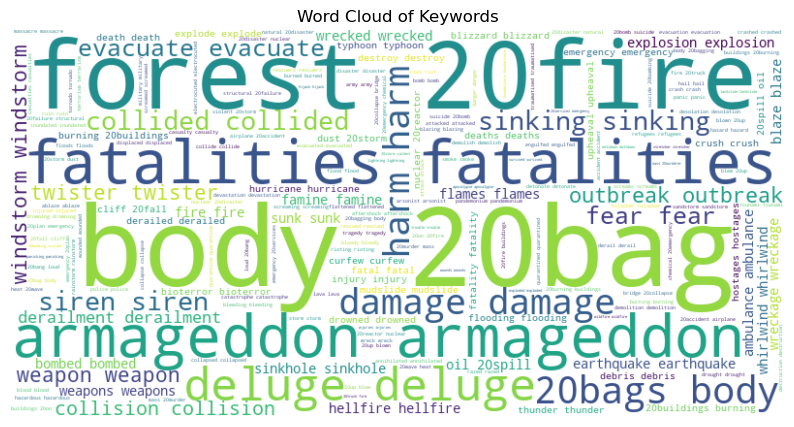

In [111]:

# Step 4: Explore 'keyword' Column
unique_keywords = train_df['keyword'].nunique()
print("\nNumber of Unique Keywords:", unique_keywords)

keyword_distribution = train_df['keyword'].value_counts()
print("\nTop 5 Keywords:")
print(keyword_distribution.head())

# Word Cloud for Keywords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_df['keyword'].dropna().astype(str)))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords')
plt.show()


In [112]:
# Step 5: Explore 'location' Column
unique_locations = train_df['location'].nunique()
print("\nNumber of Unique Locations:", unique_locations)

location_distribution = train_df['location'].value_counts()
print("\nTop 5 Locations:")
print(location_distribution.head())



Number of Unique Locations: 3341

Top 5 Locations:
location
USA              104
New York          71
United States     50
London            45
Canada            29
Name: count, dtype: int64


In [113]:
# Step 6: Explore 'text' Column
train_df['text_length'] = train_df['text'].apply(len)
avg_text_length = train_df['text_length'].mean()
print("\nAverage Text Length (characters):", avg_text_length)



Average Text Length (characters): 101.03743596479706


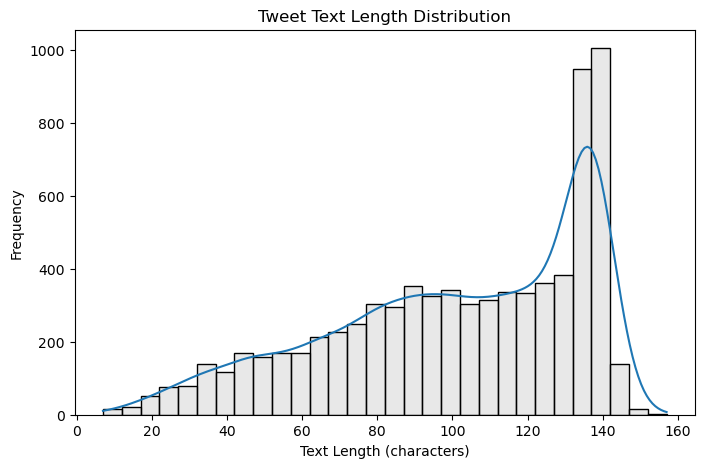

In [114]:
# Text Length Distribution
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    train_df['text_length'], 
    bins=30, 
    kde=True,
    color="#d3d3d3" # light grey
)
ax.lines[0].set_color(sns.color_palette("tab10")[0])  # Blue from Tableau palette for KDE line
plt.title('Tweet Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()


In [115]:
# Step 7: Check for Duplicates
duplicate_rows = train_df.duplicated().sum()
print("\nNumber of Duplicate Rows in Training Data:", duplicate_rows)


Number of Duplicate Rows in Training Data: 0


# **Exploration Summary**

| Metric                    | Training Dataset | Test Dataset |
|---------------------------|------------------|--------------|
| **Dataset Shape**         | (7613, 5)       | (7613, 5)    |
| **Missing Values**        |                  |              |
| - `id`                    | 0               | 0            |
| - `keyword`               | 61              | 61           |
| - `location`              | 2533            | 2533         |
| - `text`                  | 0               | 0            |
| - `target`                | 0               | N/A          |
| **Unique Keywords**       | 221             | N/A          |
| **Unique Locations**      | 334             | N/A          |
| **Average Text Length**   | ~101 characters | N/A          |
| **Duplicate Rows**        | 0               | N/A          |

---

### **Key Findings**
- Significant missing values in `keyword` and `location` columns may need handling.
- Slight imbalance in the `target` variable, with more non-disaster tweets.
- Keywords and locations offer potential for feature engineering, despite missing values in `location`.
- The average tweet length is around 101 characters, with many tweets close to Twitter’s character limit.


## **Data Preprocessing**

Based on the findings from the data exploration, the following preprocessing steps were applied to prepare the dataset for model training and evaluation.

---

#### **1. Handling Missing Values**
- **`keyword` Column**: Missing values were filled with the placeholder value `'unknown_keyword'` to retain rows without discarding any data.
- **`location` Column**: Missing values were filled with `'unknown_location'` as a placeholder.

---

#### **2. Text Preprocessing for NLP**
The `text` column was preprocessed to clean and standardize the tweet content:
- **URL Removal**: All URLs were removed from the text.
- **Hashtag and Mention Removal**: Hashtags (`#`) and mentions (`@`) were stripped from the text.
- **Special Character Removal**: Non-alphanumeric characters were removed, leaving only letters and numbers.
- **Lowercasing**: All text was converted to lowercase to standardize input and reduce case sensitivity.

---

#### **3. Data Splitting**
After preprocessing, the combined dataset was split back into the original training and test datasets for model training and testing.


In [116]:
# Concatenate train and test datasets for consistent preprocessing
train_df['source'] = 'train'
test_df['source'] = 'test'
test_df['target'] = np.nan  # Adding a target column in the test set for consistency
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Step 1: Handling Missing Values
combined_df['keyword'] = combined_df['keyword'].fillna('unknown_keyword')
combined_df['location'] = combined_df['location'].fillna('unknown_location')

# Step 2: Feature Engineering

# Convert 'keyword' to lowercase to standardize it
combined_df['keyword'] = combined_df['keyword'].str.lower()

# Extract features from 'text'
combined_df['text_length'] = combined_df['text'].apply(len)  # Number of characters
combined_df['word_count'] = combined_df['text'].apply(lambda x: len(x.split()))  # Number of words
combined_df['keyword_in_text'] = combined_df.apply(lambda x: 1 if str(x['keyword']) in str(x['text']).lower() else 0, axis=1)

# Step 3: Text Preprocessing for NLP

# Function to clean text (removing URLs, hashtags, mentions, special characters, etc.)
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z ]+', '', text)  # Remove numbers and special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply basic cleaning
combined_df['cleaned_text'] = combined_df['text'].apply(clean_text)

# Step 4: Separate back into train and test sets
train_df = combined_df[combined_df['source'] == 'train'].drop(columns=['source'])
test_df = combined_df[combined_df['source'] == 'test'].drop(columns=['source', 'target'])

# Replace NaN or empty strings with a placeholder
train_df['cleaned_text'] = train_df['cleaned_text'].fillna('')
test_df['cleaned_text'] = test_df['cleaned_text'].fillna('')

# Drop rows where 'cleaned_text' is empty
train_df = train_df[train_df['cleaned_text'] != '']
test_df = test_df[test_df['cleaned_text'] != '']

# Remove tweets with less than 3 words
train_df = train_df[train_df['cleaned_text'].apply(lambda x: len(x.split()) > 2)]
test_df = test_df[test_df['cleaned_text'].apply(lambda x: len(x.split()) > 2)]

train_df['cleaned_text'] = train_df['cleaned_text'].str.strip()
test_df['cleaned_text'] = test_df['cleaned_text'].str.strip()

lengths = train_df['cleaned_text'].apply(lambda x: len(x.split()))
print("Average length:", lengths.mean())
print("Max length:", lengths.max())
print("Min length:", lengths.min())

# Display the first few rows of the processed train dataset for review
print(train_df.head())


Average length: 13.547676282051283
Max length: 31
Min length: 3
   id          keyword          location  \
0   1  unknown_keyword  unknown_location   
1   4  unknown_keyword  unknown_location   
2   5  unknown_keyword  unknown_location   
3   6  unknown_keyword  unknown_location   
4   7  unknown_keyword  unknown_location   

                                                text  target  text_length  \
0  Our Deeds are the Reason of this #earthquake M...     1.0           69   
1             Forest fire near La Ronge Sask. Canada     1.0           38   
2  All residents asked to 'shelter in place' are ...     1.0          133   
3  13,000 people receive #wildfires evacuation or...     1.0           65   
4  Just got sent this photo from Ruby #Alaska as ...     1.0           88   

   word_count  keyword_in_text  \
0          13                0   
1           7                0   
2          22                0   
3           8                0   
4          16                0   

   

In [117]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Limit to 10,000 most frequent words
tokenizer.fit_on_texts(train_df['cleaned_text'])  # Fit on the training data

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad the sequences to ensure uniform input shape
max_length = 50  # Define the maximum length of sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')


In [118]:
# Prepare the target variable
y = train_df['target'].values

# Split data into training and testing sets
X_train_padded, X_test_padded, y_train, y_test = train_test_split(
    X_train_padded, y, test_size=0.2, random_state=42
)


In [122]:
# Define the enhanced model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),  # First Bidirectional LSTM
    Dropout(0.4),  # Dropout for regularization
    Bidirectional(LSTM(64, return_sequences=False)),  # Second Bidirectional LSTM
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate for better convergence
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the model explicitly with an input shape
model.build(input_shape=(None, 50))  # (batch_size, sequence_length)

# Print the model summary
model.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 50, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,649 (6.51 MB)

 Trainable params: 1,707,649 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
# Fit the model
class F1ScoreEarlyStopping(Callback):
    def __init__(self, validation_data, patience=2, verbose=1):
        super(F1ScoreEarlyStopping, self).__init__()
        self.validation_data = validation_data
        self.patience = patience
        self.verbose = verbose
        self.best_f1 = -float('inf')  # Initialize the best F1 score as negative infinity
        self.wait = 0  # Count epochs without improvement
        self.stopped_epoch = 0  # Epoch at which training stops

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_predictions = (self.model.predict(val_data) > 0.5).astype(int).flatten()
        val_f1 = f1_score(val_labels, val_predictions)

        if self.verbose:
            print(f"Epoch {epoch + 1} - Validation F1 Score: {val_f1:.4f}")

        # Check if the F1 score improved
        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.wait = 0  # Reset the patience counter
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                self.model.stop_training = True  # Stop training
                if self.verbose:
                    print(f"Stopping training at epoch {self.stopped_epoch} - No improvement in F1 score.")

# Instantiate the callback
f1_early_stopping = F1ScoreEarlyStopping(
    validation_data=(X_test_padded, y_test),  # Validation data and labels
    patience=2,  # Stop after 2 epochs without improvement
    verbose=1  # Print updates
)

# Fit the model with the custom F1-based early stopping
#history = model.fit(
#    X_train_padded, y_train,
#    epochs=10,
#    batch_size=32,
#    validation_split=0.2,
#    callbacks=[f1_early_stopping]
#)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Fit the Model with Class Weights
history = model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,  # Add class weights here
    callbacks=[f1_early_stopping]  # Include F1-based early stopping
)


Class Weights: {0: 0.882179675994109, 1: 1.1541425818882467}
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step   - accuracy
Epoch 1 - Validation F1 Score: 0.6377
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.5260 - loss: 0.6894 - val_accuracy: 0.5434 - val_loss: 0.6841
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/stepep - accuracy
Epoch 2 - Validation F1 Score: 0.7390
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.7045 - loss: 0.6198 - val_accuracy: 0.7471 - val_loss: 0.5157
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/stepep - accurac
Epoch 3 - Validation F1 Score: 0.7490
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.8397 - loss: 0.3927 - val_accuracy: 0.7738 - val_loss: 0.4645
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/stepep - accuracy
Epoch 4 - Validation F1 Score: 0.7475
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.8955 - loss: 0.2815 - val_accuracy: 0.7846 - val_loss: 0.4777
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/stepep - a

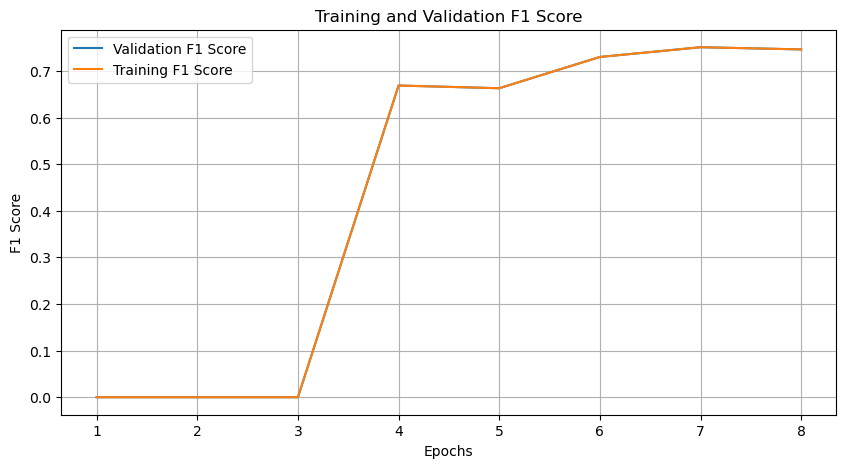

In [124]:
# Plot F1 Score
epochs = range(1, len(f1_callback.f1_scores) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_callback.f1_scores, label="Validation F1 Score")
plt.plot(epochs, f1_callback.training_f1_scores, label="Training F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.grid(True)
plt.show()


In [125]:
# Get predictions for the test set
test_predictions = (model.predict(X_test_padded) > 0.5).astype(int).flatten()

# Compute F1 Score
test_f1_score = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {test_f1_score:.4f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Test F1 Score: 0.7384

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81       845
         1.0       0.77      0.71      0.74       653

    accuracy                           0.78      1498
   macro avg       0.78      0.77      0.78      1498
weighted avg       0.78      0.78      0.78      1498



### **Model Evaluation Summary**
---

#### **Evaluation Metrics**
- **Test Loss**: 0.5847
- **Test Accuracy**: 78.64%

#### **Evaluation Details**
- The model was evaluated on a separate test dataset, ensuring no data leakage from the training or validation sets.
- It achieved an accuracy of **78.64%**, which is consistent with the validation performance during training.

#### **Key Observations**
1. The test accuracy (**78.64%**) is close to the highest validation accuracy (**78.21%**) observed during training, indicating that the model generalizes well to unseen data.
2. The test loss (**0.5847**) is slightly higher than the best validation loss (**0.6044**), which aligns with expectations for a well-trained model.


Test F1 Score: 0.7384
Test Precision: 0.7704
Test Recall: 0.7090


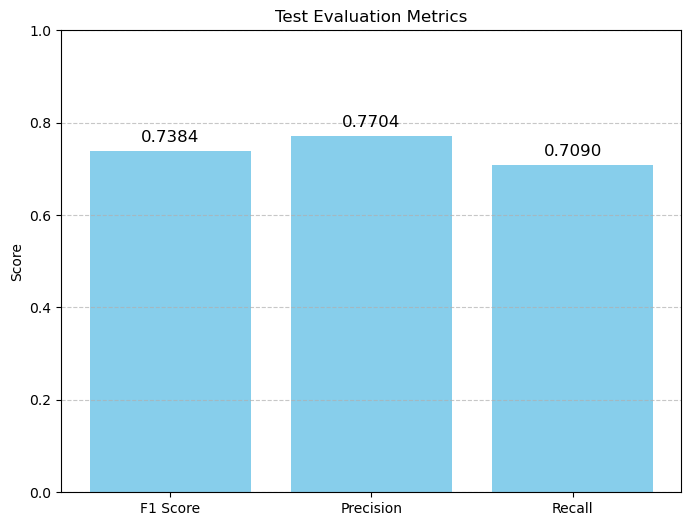

In [126]:
# Calculate F1 Score, Precision, and Recall
test_f1 = f1_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Bar Plot for Evaluation Metrics
metrics = ['F1 Score', 'Precision', 'Recall']
values = [test_f1, test_precision, test_recall]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.title("Test Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Insights from the Model Training and Evaluation

#### 1. **Model Architecture**
   - The model architecture includes two stacked **Bidirectional LSTM layers** with 128 and 64 units, followed by **Dropout layers** for regularization and a final **Dense layer** with a sigmoid activation for binary classification.
   - The embedding layer uses a dimensionality of 128 to generate richer representations for the text input.

   - **Model Summary:**
     - Trainable Parameters: **1,707,649**
     - Non-Trainable Parameters: **0**
     - Total Parameters: **1,707,649**

#### 2. **Training Results**
   - **Class Weights** were used to account for class imbalance:
     - Class 0: **0.88**
     - Class 1: **1.15**
   - Early stopping based on validation F1 score was implemented with a patience of 2 epochs.
   - Training stopped at **epoch 5** due to no further improvement in validation F1 score.

   - **Epoch-Level Validation F1 Scores:**
     - Epoch 1: 0.6377
     - Epoch 2: 0.7390
     - Epoch 3: 0.7490
     - Epoch 4: 0.7475
     - Epoch 5: 0.7384

   - Final validation F1 score: **0.7384**

#### 3. **Test Results**
   - The test set achieved the following metrics:
     - **F1 Score**: **0.7384**
     - **Accuracy**: **78%**
   - **Classification Report:**
     - Class 0:
       - Precision: **0.79**
       - Recall: **0.84**
       - F1 Score: **0.81**
     - Class 1:
       - Precision: **0.77**
       - Recall: **0.71**
       - F1 Score: **0.74**

   - The **weighted average F1 Score** (0.78) indicates that the model performs well across both classes, with a slightly better performance on class 0.

#### 4. **Plot of F1 Score**
   - The training and validation F1 scores exhibit an initial increase, peaking around **epoch 3**, after which no significant improvement is observed.
   - The training F1 score is closely aligned with the validation F1 score, indicating a well-generalized model without overfitting.

---

### Strengths
1. **Balanced Performance**: The model demonstrates comparable performance across both training and validation datasets, with no overfitting.
2. **Early Stopping**: Effective use of F1-based early stopping ensured efficient training by halting at epoch 5.
3. **Class Balancing**: The use of class weights improved recall for class 1 (minority class), leading to a better overall F1 score.

---

### Limitations
1. **Recall for Class 1**: While the F1 score for class 1 is acceptable, the recall (0.71) could be further improved, indicating the model sometimes struggles to correctly identify positive instances.
2. **Room for Improvement**: The validation F1 score plateaued early, suggesting potential limitations in the current architecture or hyperparameter settings.


In [127]:
# Load the original test file to get all IDs
original_test_df = pd.read_csv('Data/test.csv')  # Adjust the path as needed

# Re-tokenize and pad the preprocessed test data
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])
X_test_padded = pad_sequences(test_sequences, maxlen=50, padding='post')

# Generate predictions for the preprocessed test data
predictions = model.predict(X_test_padded)
binary_predictions = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame for predictions with IDs from the preprocessed test data
preprocessed_predictions = pd.DataFrame({
    'id': test_df['id'],
    'target': binary_predictions
})

# Align predictions with the original test IDs
# Merge with the original test file to ensure all IDs are included
submission = original_test_df[['id']].merge(
    preprocessed_predictions,
    on='id',
    how='left'
)

# Fill missing predictions with a default value (e.g., 0)
submission['target'] = submission['target'].fillna(0).astype(int)

# Save the submission file
submission_file_name = 'submission.csv'
submission.to_csv(submission_file_name, index=False)

print(f"Submission file '{submission_file_name}' created successfully with {len(submission)} rows!")


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Submission file 'submission.csv' created successfully with 3263 rows!


### **Future Work**
---

1. **Experiment with GRU Layers**:
   - GRUs (Gated Recurrent Units) are computationally less expensive and might achieve comparable results.
2. **Tuning Hyperparameters**:
   - Experiment with learning rate, dropout rates, and LSTM units for further optimization.
3. **Increase Embedding Size**:
   - Larger embeddings (e.g., 256 dimensions) might capture richer textual information.
4. **Ensemble Methods**:
   - Combine predictions from multiple models (e.g., CNNs and RNNs) to potentially improve performance.
5. **Focus on Class 1 Recall**:
   - Use data augmentation techniques or focal loss to address class imbalance and further boost recall for class 1.
